In [3]:
import pandas as pd
import numpy as np
import json
import re
from plotnine import *
import plotnine


%matplotlib inline
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumBarunGothic'
plt.rcParams["font.size"] = 20
plt.rcParams["figure.figsize"] = (15,8)


# pandas max row 
pd.options.display.max_rows = 3000

In [6]:
b_unit = pd.read_csv('data/전유부.csv', dtype={
    '건물명':object, 
    '시군구코드': object, 
    '법정동코드' : object, 
    '층번호': np.int64, 
    '번' : object, 
    '지' : object, 
    '층구분코드': object 
    }
)

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.


<AxesSubplot:>

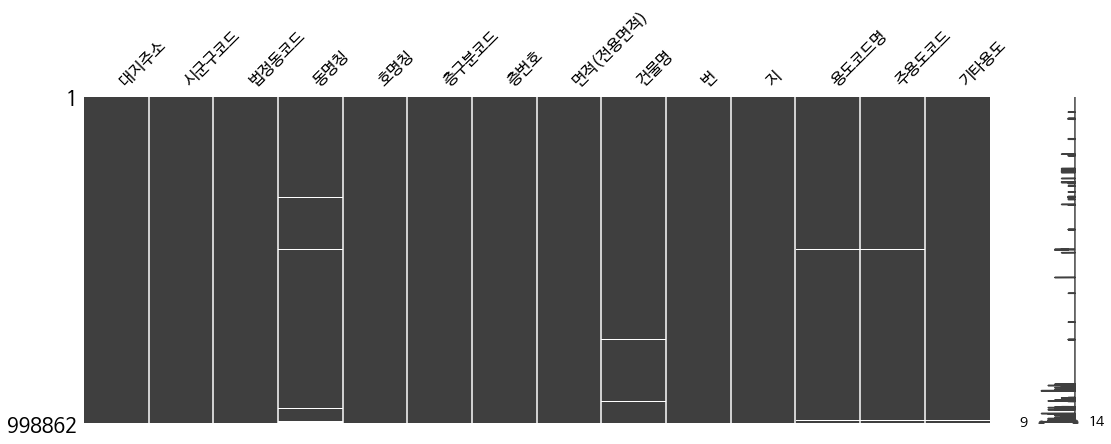

In [9]:
# 결측치 보기
import missingno as msno
msno.matrix(b_unit, figsize=(18,6))

### 아파트 건물 > 건물별 면적 > 3개월 평균 거래가

In [33]:
# 아파트건물 추출

In [134]:
bld_null = b_unit[b_unit['건물명'].isnull()]
bid_null = bld_null[bld_null['기타용도'].str.contains('아파트',na=False)]
bid_null.tail(30), bid_null.shape

(                             대지주소  시군구코드  법정동코드            동명칭   호명칭 층구분코드  \
 934107    세종특별자치시  조치원읍 죽림리 389번지  36110  25030  조치원죽림푸르지오101동  304호    20   
 934114    세종특별자치시  조치원읍 죽림리 389번지  36110  25030  조치원죽림푸르지오103동  701호    20   
 934120    세종특별자치시  조치원읍 죽림리 389번지  36110  25030  조치원죽림푸르지오102동  101호    20   
 934127    세종특별자치시  조치원읍 죽림리 389번지  36110  25030  조치원죽림푸르지오101동  604호    20   
 949730  세종특별자치시  조치원읍 번암리 66-14번지  36110  25031            제1동   201    20   
 949738  세종특별자치시  조치원읍 번암리 66-14번지  36110  25031            제1동   202    20   
 949746  세종특별자치시  조치원읍 번암리 66-14번지  36110  25031            제1동   204    20   
 949754  세종특별자치시  조치원읍 번암리 66-14번지  36110  25031            제1동   203    20   
 949762  세종특별자치시  조치원읍 번암리 66-14번지  36110  25031            제1동   301    20   
 949770  세종특별자치시  조치원읍 번암리 66-14번지  36110  25031            제1동   302    20   
 949778  세종특별자치시  조치원읍 번암리 66-14번지  36110  25031            제1동   304    20   
 949786  세종특별자치시  조치원읍 번암리 66-14번지  36110  25031    

In [162]:
# 동명칭에 건물명이 있는 경우, 조치원죽림푸르지오만 누락
missing_name = '조치원죽림푸르지'
for i in range(len(bid_null.index)) :
    bid_null[1] = bid_null['동명칭'].str.split('오').str[0]

    if bid_null[1].iloc[i] == missing_name :
        bid_null['건물명'].iloc[i] = missing_name + '오'
        bid_null['동명칭'].iloc[i] = bid_null['동명칭'].iloc[i].split('오')[-1]
            
    else :
        pass
    
    bid_null = bid_null.drop(1,axis=1)
bid_null.tail(30)

,대지주소,시군구코드,법정동코드,동명칭,호명칭,층구분코드,층번호,면적(전용면적),건물명,번,지,용도코드명,주용도코드,기타용도,2
934107,세종특별자치시 조치원읍 죽림리 389번지,36110,25030,조치원죽림푸르지,304호,20,3,84.9228,조치원죽림푸르지오,0389,0000,아파트,2001,아파트,NaN
934114,세종특별자치시 조치원읍 죽림리 389번지,36110,25030,조치원죽림푸르지,701호,20,7,104.9044,조치원죽림푸르지오,0389,0000,아파트,2001,아파트,NaN
934120,세종특별자치시 조치원읍 죽림리 389번지,36110,25030,조치원죽림푸르지,101호,20,1,84.9228,조치원죽림푸르지오,0389,0000,아파트,2001,아파트,NaN
934127,세종특별자치시 조치원읍 죽림리 389번지,36110,25030,조치원죽림푸르지,604호,20,6,84.9228,조치원죽림푸르지오,0389,0000,아파트,2001,아파트,NaN
949730,세종특별자치시 조치원읍 번암리 66-14번지,36110,25031,제1동,201,20,2,79.8541,NaN,0066,0014,아파트,2001,아파트,NaN
949738,세종특별자치시 조치원읍 번암리 66-14번지,36110,25031,제1동,202,20,2,73.1656,NaN,0066,0014,아파트,2001,아파트,NaN
949746,세종특별자치시 조치원읍 번암리 66-14번지,36110,25031,제1동,204,20,2,59.4855,NaN,0066,0014,아파트,2001,아파트,NaN
949754,세종특별자치시 조치원읍 번암리 66-14번지,36110,25031,제1동,203,20,2,72.4326,NaN,0066,0014,아파트,2001,아파트,NaN
949762,세종특별자치시 조치원읍 번암리 66-14번지,36110,25031,제1동,301,20,3,79.8541,NaN,0066,0014,아파트,2001,아파트,NaN
949770,세종특별자치시 조치원읍 번암리 66-14번지,36110,25031,제1동,302,20,3,73.1656,NaN,0066,0014,아파트,2001,아파트,NaN
